<a href="https://colab.research.google.com/github/kittikhun62/efficientnet_keras_transfer_learning/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#เรียกใช้ CSV

In [1]:
import pandas as pd
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv (r'/content/drive/My Drive/data - All SEM.csv')
df

,No,Name_file,Name_Paper,journal,path_Picture,detail,Class,BET,Size(mico)
0,1,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,original,0-500,135.06,5
1,2,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom1,0-500,135.06,10
2,3,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom2,0-500,135.06,10
3,4,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom3,0-500,135.06,10
4,5,pore-sb,Preparation and electrochemical behaviour of b...,Korean J. Chem. Eng,/content/drive/My Drive/All SEM/pore-sb/PCC(RS...,zoom4,0-500,135.06,10
...,...,...,...,...,...,...,...,...,...
315,316,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,11.00,10
316,317,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,0.25,10
317,318,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,0-500,35.00,10
318,319,1-s2.0-S0926669022000292-main,Low-cost activated carbon preparation from Cor...,Industrial Crops & Products,/content/drive/My Drive/All SEM/1-s2.0-S092666...,original,501-1000,583.00,10


## hist


In [4]:
import matplotlib.pyplot as plt

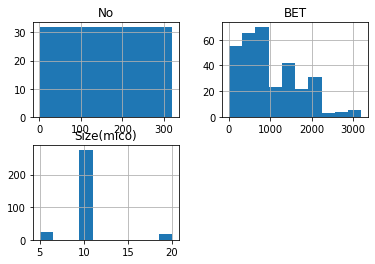

In [5]:
df.hist();

In [6]:
a = df['BET']

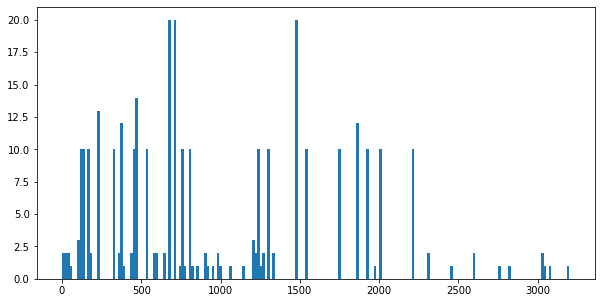

In [7]:
fig, ax = plt.subplots(figsize =(10, 5))
ax.hist(a, bins = 200)
plt.show()

In [8]:
classes = ['0-500','501-1000','1001-3200']
len(classes)

3

#Imports

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#กำหนดค่าพารามิเตอร์


In [18]:
batch_size = 20

width = 150
height = 150

epochs = 20 #จำนวนรอบในการ Train

NUM_TRAIN = 300  # จำนวนภาพ Train
NUM_TEST = 20 #จำนวนภาพ Test

dropout_rate = 0.2
input_shape = (height, width, 3) #ขนาด image enter

#Clone efficientnet repo


In [19]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/


/content
/content/efficientnet_keras_transfer_learning


In [20]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [21]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
#EfficientNet สร้างขึ้นสำหรับการจำแนกประเภท ImageNet ประกอบด้วยป้ายกำกับคลาส 1,000 รายการ เรามีเพียง 2 เลเยอร์เท่านั้น ซึ่งหมายความว่าเลเยอร์สองสามเลเยอร์สุดท้ายสำหรับการจำแนกไม่มีประโยชน์สำหรับเรา สามารถยกเว้นได้ขณะโหลดโมเดลโดยระบุอาร์กิวเมนต์ include_top เป็น False และนำไปใช้กับโมเดล ImageNet อื่นๆ ที่มีอยู่ในแอปพลิเคชัน Keras เช่นกัน

conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

In [22]:
              conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_65 (Conv2D)             (None, 75, 75, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_49 (BatchN  (None, 75, 75, 32)  128         ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                    

#Download 

In [23]:
base_dir = '/content/drive/My Drive/Project'
os.makedirs(base_dir, exist_ok=True)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [24]:
train_1_dir = os.path.join(train_dir, '0-500')
os.makedirs(train_1_dir, exist_ok=True)

train_2_dir = os.path.join(train_dir, '501-1000')
os.makedirs(train_2_dir, exist_ok=True)

train_3_dir = os.path.join(train_dir, '1001-3200')
os.makedirs(train_3_dir, exist_ok=True)



validation_1_dir = os.path.join(validation_dir, '0-500')
os.makedirs(validation_1_dir, exist_ok=True)

validation_2_dir = os.path.join(validation_dir, '501-1000')
os.makedirs(validation_2_dir, exist_ok=True)

validation_3_dir = os.path.join(validation_dir, '1001-3200')
os.makedirs(validation_3_dir, exist_ok=True)



test_1_dir = os.path.join(test_dir, '0-500')
os.makedirs(test_1_dir, exist_ok=True)

test_2_dir = os.path.join(test_dir, '501-1000')
os.makedirs(test_2_dir, exist_ok=True)

test_3_dir = os.path.join(test_dir, '1001-3200')
os.makedirs(test_3_dir, exist_ok=True)





In [25]:
val = df[df['No'].between(257,289)]
train = df[df['No'].between(1,256)]
test = df[df['No'].between(290,320)] 

#Path Train
T1_train = train[train['Class']=='0-500' ]
T1_path_train = T1_train['path_Picture'].tolist() 
T2_train = train[train['Class']=='501-1000' ]
T2_path_train = T2_train['path_Picture'].tolist() 
T3_train = train[train['Class']=='1001-3200' ]
T3_path_train = T3_train['path_Picture'].tolist()

#Path Validation
T1_val = val[val['Class']=='0-500' ]
T1_path_val = T1_val['path_Picture'].tolist() 
T2_val = val[val['Class']=='501-1000' ]
T2_path_val = T2_val['path_Picture'].tolist() 
T3_val = val[val['Class']=='1001-3200']
T3_path_val = T3_val['path_Picture'].tolist()


#Path Test
T1_test = test[test['Class']=='0-500' ]
T1_path_test = T1_test['path_Picture'].tolist() 
T2_test = test[test['Class']=='501-1000' ]
T2_path_test = T2_test['path_Picture'].tolist() 
T3_test = test[test['Class']=='1001-3200']
T3_path_test = T3_test['path_Picture'].tolist()


#Train

In [26]:
fnames = T1_path_train
for fname in fnames:
    dst = os.path.join(train_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_train
for fname in fnames:
    dst = os.path.join(train_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_train 
for fname in fnames:
    dst = os.path.join(train_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)




#Validation

In [27]:
fnames = T1_path_test
for fname in fnames:
    dst = os.path.join(validation_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_test
for fname in fnames:
    dst = os.path.join(validation_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_test 
for fname in fnames:
    dst = os.path.join(validation_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)



# Test



In [28]:
fnames = T1_path_val
for fname in fnames:
    dst = os.path.join(test_1_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

fnames = T2_path_val
for fname in fnames:
    dst = os.path.join(test_2_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)
    
fnames = T3_path_val 
for fname in fnames:
    dst = os.path.join(test_3_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)



In [29]:
print('total training 1 images:', len(os.listdir(train_1_dir))) 
print('total training 2 images:', len(os.listdir(train_2_dir)))
print('total training 3 images:', len(os.listdir(train_3_dir)),'\n')


print('total validation 1 images:', len(os.listdir(validation_1_dir)))
print('total validation 2 images:', len(os.listdir(validation_2_dir)))
print('total validation 3 images:', len(os.listdir(validation_3_dir)),'\n')


print('total test 1 images:', len(os.listdir(test_1_dir)))
print('total test 2 images:', len(os.listdir(test_2_dir)))
print('total test 3 images:', len(os.listdir(test_3_dir)),'\n')


total training 1 images: 82
total training 2 images: 70
total training 3 images: 104 

total validation 1 images: 9
total validation 2 images: 10
total validation 3 images: 12 

total test 1 images: 16
total test 2 images: 6
total test 3 images: 11 



# Setting data augmentation

In [55]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
#Image Augmentation 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, # image input 0-255 --> 0-1 เปลี่ยนค่าสี
      rotation_range=40,# หมุนภาพในองศา
      width_shift_range=0.2, #เปลี่ยนความกว้าง
      height_shift_range=0.2, #ปลี่ยนความสูง
      shear_range=0.2, #ทำให้ภาพเบี้ยว
      zoom_range=0.2, # Randomly zoom image
      horizontal_flip=True, 
      #โดย Default เมื่อมีการเลื่อนภาพ บิดภาพ หมุนภาพ จะเกิดพื้นที่ว่างที่มุม 
      #ซึ่งจะมีการเติมภาพให้เต็มโดยใช้เทคนิคแบบ Nearest neighbor ซึ่งเป็นการดึงสีบริเวณใหล้าเคียงมาระบายให้เต็ม แต่เราก็ยังสามารถกำหนดวิธีการ Fill ภาพด้วยเทคนิคอื่นได้จาก Parameter fill_mode
      fill_mode='nearest')
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory #ไดเรกเป้าหมาย
        train_dir,
        # รูปภาพทั้งหมดจะถูกปรับขนาดตามความสูงและความกว้างของเป้าหมาย
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        #เนื่องจากเราใช้ categorical_crossentropy loss เราจึงต้องมีป้ายกำกับตามหมวดหมู่
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory( #การดึงภาพจาก Directory มาเข้าโมเดล 
        validation_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
     

Found 256 images belonging to 3 classes.
Found 31 images belonging to 3 classes.


In [30]:
#ดัดแปลง GlobalMaxPooling2D เพื่อแปลง 4D the (batch_size, rows, cols,channels) tensor เป็น 2D tensor with shape (batch_size,channels)
#GlobalMaxPooling2D ส่งผลให้มีจำนวนฟีเจอร์น้อยกว่ามากเมื่อเทียบกับเลเยอร์ Flatten ซึ่งช่วยลดจำนวนพารามิเตอร์ได้อย่างมีประสิทธิภาพ

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(3, activation='softmax', name="fc_out"))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 5, 5, 1280)       4049564   
 )                                                               
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 3)                 3843      
                                                                 
Total params: 4,053,407
Trainable params: 4,011,391
Non-trainable params: 42,016
_________________________________________________________________


In [56]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 203
This is the number of trainable layers after freezing the conv base: 2


In [57]:
#model.compile(loss='categorical_crossentropy',
              #optimizer=optimizers.RMSprop(lr=2e-5),
             # metrics=['acc'])

#history คือตัวแปรที่จะทำการเก็บประวัติการ Train Model ของเรา
#คำสั่ง Train

#history = model.fit_generator(
     # train_generator, #โหลดdataเข้ามา
      #steps_per_epoch= NUM_TRAIN //batch_size,
      #epochs=epochs,
      #validation_data=validation_generator, #validation_data=(x_valid, y_valid): ใส่ data ที่เราแยกไว้เพื่อดูผล
     # validation_steps= NUM_TEST //batch_size,
      #verbose=1, #โชว์ผลลัพธ์ 0:ปิด
     # use_multiprocessing=True, #ใช้ GPU หลายตัว
     # workers=4) #ทำพร้อมกันที่ละ 4 ตัว

In [39]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
<ipython-input-39-bbda3a575f01>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
15/15 [==============================] - 28s 1s/step - loss: 2.0877 - acc: 0.3108 - val_loss: 1.5231 - val_acc: 0.3000
Epoch 2/20
15/15 [==============================] - 15s 890ms/step - loss: 1.7228 - acc: 0.3390 - val_loss: 1.5220 - val_acc: 0.3000
Epoch 3/20
15/15 [==============================] - 15s 875ms/step - loss: 1.6894 - acc: 0.3615 - val_loss: 1.5026 - val_acc: 0.3000
Epoch 4/20
15/15 [==============================] - 15s 895ms/step - loss: 1.7165 - acc: 0.3459 - val_loss: 1.2424 - val_acc: 0.3500
Epoch 5/20
15/15 [==============================] - 15s 889ms/step - loss: 1.7189 - acc: 0.3412 - val_loss: 1.2497 - val_acc: 0.2500
Epoch 6/20
15/15 [==============================] - 15s 864ms/step - loss: 1.6252 - acc: 0.3547 - val_loss: 1.2615 - val_acc: 0.3500
Epoch 7/20
15/15 [==============================] - 15s 843ms/step - loss: 1.6391 - acc: 0.3581 - val_loss: 1.3239 - val_acc: 0.3000
Epoch 8/20
15/15 [==============================] - 15s 840ms/step - los

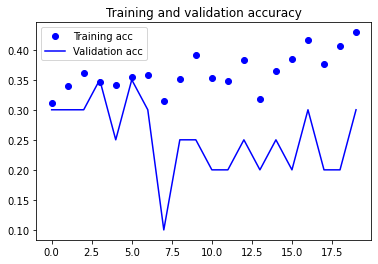

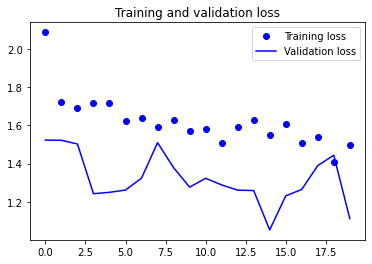

In [40]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning last several layers.

In [41]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
     

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-42-4287107a2cee>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
15/15 [==============================] - 75s 3s/step - loss: 3.1548 - acc: 0.3953 - val_loss: 1.4259 - val_acc: 0.3000
Epoch 2/20
15/15 [==============================] - 55s 3s/step - loss: 2.6348 - acc: 0.4291 - val_loss: 1.5552 - val_acc: 0.2500
Epoch 3/20
15/15 [==============================] - 46s 3s/step - loss: 2.2905 - acc: 0.4392 - val_loss: 1.8326 - val_acc: 0.3000
Epoch 4/20
15/15 [==============================] - 50s 3s/step - loss: 2.0073 - acc: 0.4291 - val_loss: 1.9982 - val_acc: 0.4500
Epoch 5/20
15/15 [==============================] - 48s 3s/step - loss: 2.0770 - acc: 0.4932 - val_loss: 2.3670 - val_acc: 0.3000
Epoch 6/20
15/15 [==============================] - 48s 3s/step - loss: 1.8304 - acc: 0.4966 - val_loss: 2.0626 - val_acc: 0.4000
Epoch 7/20
15/15 [==============================] - 51s 3s/step - loss: 2.0206 - acc: 0.4932 - val_loss: 2.6964 - val_acc: 0.4000
Epoch 8/20
15/15 [==============================] - 49s 3s/step - loss: 1.7395 - acc: 0.49

In [43]:
os.makedirs("./models", exist_ok=True)
model.save('./models/SEM')

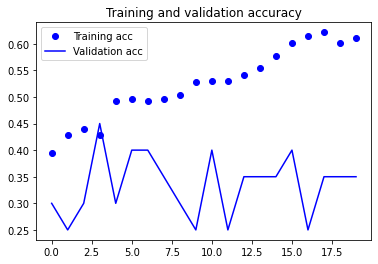

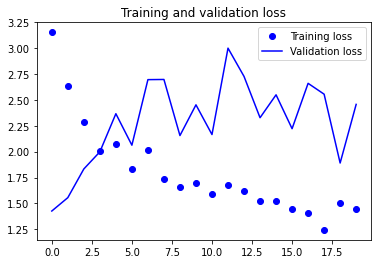

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
     

#Test predict

In [45]:
from tensorflow.keras.preprocessing import image
import pandas as pd
     

In [46]:
clases = ['0-500','501-1000','1001-3200']
results = list()

for i in clases:
    img_path =val[val['Class']==i]['path_Picture'].tolist()
    for j in img_path:
        img = image.load_img(j, target_size=(height, width))
            # Convert it to a Numpy array with target shape.
        x = image.img_to_array(img)
            # Reshape
        x = x.reshape((1,) + x.shape)
        x /= 255.
        result = model.predict([x])[0]
        n = 10
        avgDists = result
        idxs = avgDists.argsort()[::-1][:n] #sort max
        predlist,problist = list(), list()
        for m in idxs:
            pred =  clases[m]
            prob = result[m]
            predlist.append(pred)
            problist.append(prob)
        act_true = i
        prob_max = problist[0]
        pred_max = predlist[0]
     

1/1 [==============================] - 0s 59ms/step


In [78]:
 f = predlist.append(pred)
 f

In [58]:
img = T1_path_train[-1]
img1 = T1_path_test[-1]

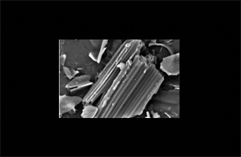

In [59]:
Image(filename=img)

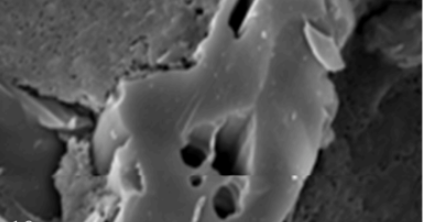

In [60]:
Image(filename=img1)

In [ ]:
#เช็คคลาสใน Predicted
pred_class = set(data_train['3Predicted'])

In [61]:
result 
     

array([0.70233434, 0.13652308, 0.16114245], dtype=float32)

In [62]:
print(pred_max,prob_max)

0-500 0.70233434


In [49]:
#res = predict_image()

In [50]:
#path = 
#class_actual =['Y7','Y8','Y9','Y10','Y11','Y12','Y13','Y16','Y17','Y18']
#class_predict =[]
#for p in range(len(path)):
   # path_ = path[p]
    #class_actual.append(class_[p])
    #res = predict_image(path_)

    #predict_prop = max(res)
    #predict_class = class_[np.argmax(res)]

    #class_predict.append(predict_class)

In [51]:
#from sklearn.metrics import confusion_matrix
 
#cm = confusion_matrix(class_actual,class_predict)
#cm

In [52]:
#from sklearn.metrics import classification_report

#target_names = ['8Years', '9Years', '10Years']
#print(classification_report(class_actual, class_predict, target_names=target_names))

# Download the model

In [53]:

#from google.colab import files

#files.download('./models/Paranoma_Fil,.h5')

In [54]:

#model.input_shape